In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed, 
                                     MultiHeadAttention, LayerNormalization, Add, 
                                     Conv1D, GlobalAveragePooling1D)

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
import os
import gc
import tensorflow.keras.backend as K
from einops import rearrange

# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 10
FORECAST_STEPS = 10
PATCH_LEN = 5
TEST_RATIO = 0  # For validation split during training
TEST_SIZE_POURCENTAGE = 1
# Tuning parameters
EPOCHS_LIST = [20]
BATCH_SIZES = [128]
WINDOW_SIZE_SIMULATION = 10  # 6h window
# Transformer parameters for anomaly detection
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
DROPOUT_RATE = 0.1
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
# Load detection dataset
file_path_detection = '../../data/cleaned_labeled_dataset.csv'
df_detection = pd.read_csv(file_path_detection, delimiter=',')
df_detection['DateTime'] = pd.to_datetime(df_detection['DateTime'], errors='coerce')
df_detection.set_index('DateTime', inplace=True)

# Load forecast dataset
file_path_forecast = '../../data/preprocessed_data.csv'
df_forecast = pd.read_csv(file_path_forecast, delimiter=',')
df_forecast['DateTime'] = pd.to_datetime(df_forecast['DateTime'], errors='coerce')
df_forecast.set_index('DateTime', inplace=True)

# Extract labels column if it exists from detection dataset
if 'labels' in df_detection.columns:
    print("✅ Found 'labels' column in detection dataset. Extracting for later evaluation.")
    labels_detection = df_detection['labels'].copy()
    df_detection_train = df_detection.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found in detection dataset. Will assume all samples are normal.")
    labels_detection = pd.Series(np.zeros(len(df_detection)))
    df_detection_train = df_detection.copy()

# Extract labels column if it exists from forecast dataset
if 'labels' in df_forecast.columns:
    print("✅ Found 'labels' column in forecast dataset. Extracting for later evaluation.")
    labels_forecast = df_forecast['labels'].copy()
    df_forecast_train = df_forecast.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found in forecast dataset. Will assume all samples are normal.")
    labels_forecast = pd.Series(np.zeros(len(df_forecast)))
    df_forecast_train = df_forecast.copy()




✅ GPU is available and will be used.
✅ Found 'labels' column in detection dataset. Extracting for later evaluation.
✅ Found 'labels' column in forecast dataset. Extracting for later evaluation.


In [2]:
# ========================
# 4. LOAD TEST SET
# ========================
# Load the test set from CSV
test_set_path = '../../data/test_set.csv'
df_test = pd.read_csv(test_set_path, delimiter=',')
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], errors='coerce')
df_test.set_index('DateTime', inplace=True)
print(f"✅ Loaded test set with {len(df_test)} samples from {test_set_path}")

# Extract labels from test set if they exist
if 'labels' in df_test.columns:
    print("✅ Found 'labels' column in test set.")
    all_test_labels = df_test['labels'].copy()
    df_test_features = df_test.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found in test set. Will assume all samples are normal.")
    all_test_labels = pd.Series(np.zeros(len(df_test)))
    df_test_features = df_test.copy()


✅ Loaded test set with 40436 samples from ../../data/test_set.csv
✅ Found 'labels' column in test set.


In [3]:
# ========================
# 5. NORMALIZE DATA
# ========================
# Normalize detection dataset
scaler_detection = MinMaxScaler()
scaled_data_detection = scaler_detection.fit_transform(df_detection_train.values)
df_detection_scaled = pd.DataFrame(scaled_data_detection, index=df_detection_train.index, 
                                  columns=df_detection_train.columns).astype(np.float32)
print(f"✅ Scaled detection dataset shape: {df_detection_scaled.shape}")

# Normalize forecast dataset
scaler_forecast = MinMaxScaler()
scaled_data_forecast = scaler_forecast.fit_transform(df_forecast_train.values)
df_forecast_scaled = pd.DataFrame(scaled_data_forecast, index=df_forecast_train.index, 
                                 columns=df_forecast_train.columns).astype(np.float32)
print(f"✅ Scaled forecast dataset shape: {df_forecast_scaled.shape}")

# Normalize test dataset - using the same scaler as detection dataset for consistency
scaled_data_test = scaler_detection.transform(df_test_features.values)
test_data_scaled = pd.DataFrame(scaled_data_test, index=df_test_features.index, 
                             columns=df_test_features.columns).astype(np.float32)
print(f"✅ Scaled test dataset shape: {test_data_scaled.shape}")



✅ Scaled detection dataset shape: (62174, 26)
✅ Scaled forecast dataset shape: (62174, 26)
✅ Scaled test dataset shape: (40436, 26)


In [4]:
# ========================
# 6. SEQUENTIAL TRAIN/TEST SPLIT FOR MODEL EVALUATION
# ========================
# Split for detection model
split_idx_detection = int((1 - TEST_RATIO) * len(df_detection_scaled))
train_data_detection = df_detection_scaled.iloc[:split_idx_detection]

# Split for forecast model
split_idx_forecast = int((1 - TEST_RATIO) * len(df_forecast_scaled))
train_data = df_forecast_scaled.iloc[:split_idx_forecast]

In [5]:
# ========================
# 5. CREATE SEQUENCES
# ========================
def create_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - forecast_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+forecast_steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)


# Create sequence labels (a sequence is anomalous if any point in it is anomalous)
def create_sequence_labels(labels, input_steps, forecast_steps):
    """
    Create sequence-level labels from point-level labels.
    A sequence is considered anomalous (1) if any point in its forecast window is anomalous.
    
    Args:
        labels: Array of point-level binary labels (0=normal, >0=anomaly)
        input_steps: Number of input steps (not used for labeling)
        forecast_steps: Number of forecast steps
        
    Returns:
        Array of sequence-level binary labels
    """
    seq_labels = []
    for i in range(len(labels) - input_steps - forecast_steps):
        # If any point in the forecast window is anomalous, mark the sequence as anomalous
        forecast_window_labels = labels[i+input_steps:i+input_steps+forecast_steps]
        # Convert any non-zero value to anomaly (1)
        is_anomalous = np.any(np.array(forecast_window_labels) > 0)
        seq_labels.append(1 if is_anomalous else 0)
    return np.array(seq_labels, dtype=np.int32)

In [6]:
TEST_SIZE_POURCENTAGE = 0.4
# Split for test set
split_idx_test = int(TEST_SIZE_POURCENTAGE * len(test_data_scaled))
test_data = test_data_scaled.iloc[:split_idx_test]

test_labels = all_test_labels.iloc[:split_idx_test]
print(f"✅ Detection model - Training samples: {len(train_data_detection)}, Testing samples: {len(test_data)}")
print(f"✅ Forecast model - Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

✅ Detection model - Training samples: 62174, Testing samples: 16174
✅ Forecast model - Training samples: 62174, Testing samples: 16174


In [7]:
# ========================
# 8. BUILD AND TRAIN TRANSFORMER AUTOENCODER FOR ANOMALY DETECTION
# ========================
def create_ae_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)

X_ae_train = create_ae_sequences(train_data_detection.values, FORECAST_STEPS)

# ========================
# 6. BUILD PATCHTST MODEL
# ========================
def build_patchtst_autoencoder(input_steps, num_features, patch_len=5, embed_dim=128, num_heads=4):
    assert input_steps % patch_len == 0, "Input steps must be divisible by patch length."
    num_patches = input_steps // patch_len

    inp = Input(shape=(input_steps, num_features))
    x = rearrange(inp, 'b (p l) f -> b p (l f)', p=num_patches, l=patch_len)
    x = Dense(embed_dim)(x)

    attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = RepeatVector(input_steps)(x)

    x = LSTM(embed_dim, return_sequences=True)(x)
    out = TimeDistributed(Dense(num_features))(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model


# ========================
# 7. TRAINING + TUNING
# ========================
best_val_rmse = np.inf
best_model = None
history_records = []

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\n🔵 Training model with epochs={epochs}, batch_size={batch_size}")
        
        model = build_patchtst_autoencoder(INPUT_STEPS, X_ae_train.shape[2], PATCH_LEN)
        es = EarlyStopping(patience=5, restore_best_weights=True)

        history = model.fit(X_ae_train, X_ae_train,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                            shuffle=False)
        
#transformer_ae.save("best_transformer_autoencoder.h5")
print("\n✅ Transformer Autoencoder trained and saved.")


🔵 Training model with epochs=20, batch_size=128
Epoch 1/20
438/438 [==============================] - 17s 20ms/step - loss: 0.0110 - val_loss: 0.0168
Epoch 2/20
438/438 [==============================] - 7s 17ms/step - loss: 0.0088 - val_loss: 0.0176
Epoch 3/20
438/438 [==============================] - 8s 17ms/step - loss: 0.0092 - val_loss: 0.0196
Epoch 4/20
438/438 [==============================] - 7s 17ms/step - loss: 0.0092 - val_loss: 0.0172
Epoch 5/20
438/438 [==============================] - 7s 17ms/step - loss: 0.0098 - val_loss: 0.0206
Epoch 6/20
438/438 [==============================] - 7s 16ms/step - loss: 0.0101 - val_loss: 0.0231

✅ Transformer Autoencoder trained and saved.


In [8]:
K.clear_session()
gc.collect()

1461

In [10]:
# Use the last 3000 points of the test data for simulation
test_data_tail = test_data.tail(15600).reset_index(drop=True)
test_labels_tail = test_labels.tail(15600).reset_index(drop=True)

# ========================
# 9. REAL-TIME SIMULATION WITH MANUAL THRESHOLD CONTROL
# ========================
simulation_X, simulation_y = create_sequences(test_data_tail.values, INPUT_STEPS, FORECAST_STEPS)
# Create corresponding labels for evaluation
simulation_labels = create_sequence_labels(test_labels_tail.values, INPUT_STEPS, FORECAST_STEPS)

#
forecast_list = []
#reconstruction_list = []
reconstruction_errors = []
#true_windows = []

# Process all samples without overlapping
step_size = WINDOW_SIZE_SIMULATION  # Use the window size as step size to avoid overlap
for i in range(0, len(simulation_X), step_size):
    # Get the current window batch (up to step_size samples)
    window_X = simulation_X[i:i+step_size]
    window_y_true = simulation_y[i:i+step_size]
    y_true = window_y_true
    if len(window_X) == 0:
        continue
    
    # Use LSTM Seq2Seq for forecasting
    #y_pred_future = best_model.predict(window_X, batch_size=128, verbose=1)
    #X_forecast = y_pred_future  # No need to expand dims as we're processing batches
    
    # Use Transformer Autoencoder for anomaly detection
    y_reconstructed = model.predict(window_y_true, batch_size=128, verbose=1)
    
    # Calculate reconstruction error for each sample in the batch
    batch_reconstruction_errors = np.mean((y_true - y_reconstructed)**2, axis=(1, 2))
    
    # Store predictions and errors
    #forecast_list.append(y_pred_future)
    #reconstruction_list.append(y_reconstructed)
    reconstruction_errors.append(batch_reconstruction_errors)
    #true_windows.append(window_y_true)

print("\n✅ Real-time simulation complete.")

1/1 [==============================] - 0s 56ms/step

✅ Real-time simulation complete.


In [ ]:
batch_reconstruction_errors

In [11]:
df_test2 = df_test.copy()
df_test3 = df_test2.copy()
df_test3 = df_test3.iloc[:split_idx_test]
df_test3 = df_test3.tail(15600).reset_index(drop=True)

In [12]:
MANUAL_THRESHOLD=None
MANUAL_PERCENTILE=70
# Flatten the reconstruction errors list for threshold calculation
all_reconstruction_errors = np.concatenate(reconstruction_errors)

# Make sure we're only considering windows where we have both predictions and labels
min_length = min(len(simulation_labels), len(all_reconstruction_errors))
true_labels_subset = simulation_labels[:min_length]
errors_subset = all_reconstruction_errors[:min_length]

# Determine threshold to use
if MANUAL_THRESHOLD is not None:
    # Use manually specified threshold
    threshold = MANUAL_THRESHOLD
    print(f"\n✅ Using manually specified threshold: {threshold:.5f}")
else:
    # Use percentile-based threshold
    threshold = np.percentile(all_reconstruction_errors, MANUAL_PERCENTILE)
    print(f"\n✅ Using {MANUAL_PERCENTILE}th percentile threshold: {threshold:.5f}")

# Apply threshold to get anomaly flags
anomaly_flags_list = [errors > threshold for errors in reconstruction_errors]
all_detected = np.concatenate([flags for flags in anomaly_flags_list])

# Make sure we're only considering windows where we have both predictions and labels
min_length = min(len(true_labels_subset), len(all_detected))
true_labels_subset = true_labels_subset[:min_length]
all_detected_subset = all_detected[:min_length]

# Print summary of anomalies
print(f"\nAnomaly detection summary:")
print(f"Number of true anomalies: {np.sum(true_labels_subset)}")
print(f"Numberof detected anomalies: {np.sum(all_detected_subset)}")

# Compute metrics
precision = precision_score(true_labels_subset, all_detected_subset, zero_division=0)
recall = recall_score(true_labels_subset, all_detected_subset, zero_division=0)
f1 = f1_score(true_labels_subset, all_detected_subset, zero_division=0)

print(f"\n📈 Anomaly Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")


✅ Using 70th percentile threshold: 0.09493

Anomaly detection summary:
Number of true anomalies: 3769
Numberof detected anomalies: 4674

📈 Anomaly Detection Evaluation:
Precision: 0.28798
Recall:    0.35712
F1 Score:  0.31884



🏷️ Creating labeled test set with 15600 samples...
✅ Labeled test set saved to: labeled_test_set_patchTST_edited.csv
   - Total samples: 15600
   - Normal samples: 2230
   - Anomalous samples: 13370


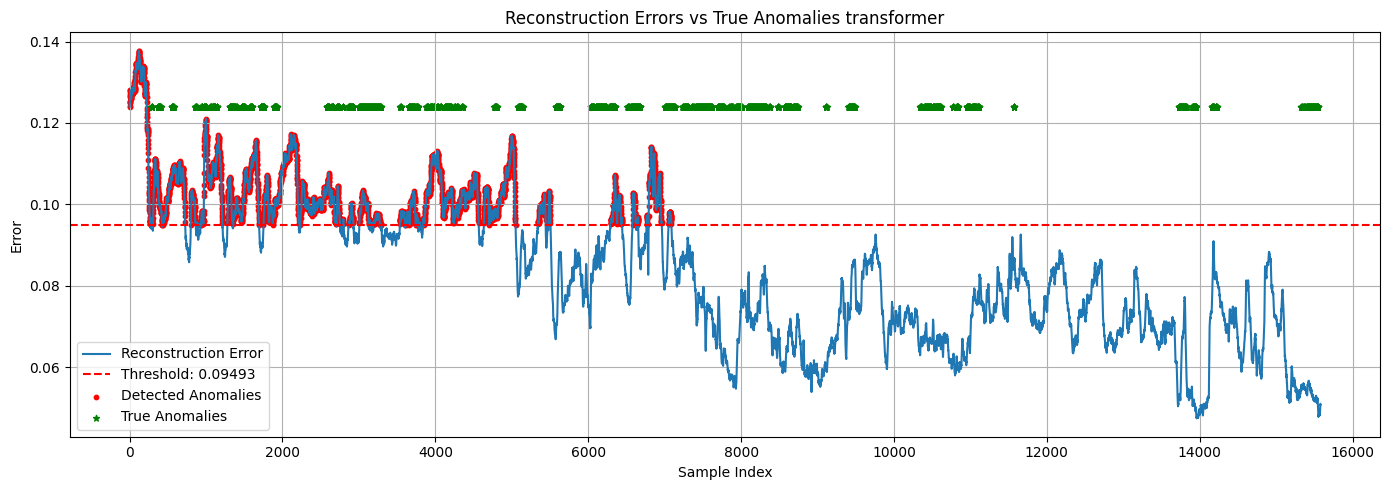


✅ Analysis complete.

To change the threshold:
1. Set MANUAL_THRESHOLD to a specific value to use that exact threshold
2. Set MANUAL_PERCENTILE to use a percentile-based threshold (current: 70th)
3. Re-run the script to see results with the new threshold


In [14]:
# ========================
# 10. CREATE LABELED TEST SET AND SAVE TO CSV
# ========================
print("\n🏷️ Creating labeled test set with 15600 samples...")

# Get original values for the 15600 test samples (inverse transform)

# Add the predicted labels to the original data
df_test3['predicted_labels'] = np.concatenate([
    np.repeat(flags, step_size)[:len(df_test3)] 
    for flags in anomaly_flags_list
])[:len(df_test3)]

# Save to CSV
output_path = 'labeled_test_set_patchTST_edited.csv'
df_test3.to_csv(output_path, index=False)
print(f"✅ Labeled test set saved to: {output_path}")
print(f"   - Total samples: {len(df_test3)}")
print(f"   - Normal samples: {np.sum(df_test3['predicted_labels'] == 0)}")
print(f"   - Anomalous samples: {np.sum(df_test3['predicted_labels'] == 1)}")

# ========================
# 10. PLOT RESULTS
# ========================
# Plot Reconstruction Errors with True Labels
plt.figure(figsize=(14,5))

# Ensure we're only plotting up to the minimum length we have data for
min_plot_len = min(len(all_reconstruction_errors), len(true_labels_subset))
plot_errors = all_reconstruction_errors[:min_plot_len]
plot_labels = true_labels_subset[:min_plot_len]
plot_detected = all_detected_subset[:min_plot_len]

plt.plot(plot_errors, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')

# Detected anomalies
detected_indices = np.where(plot_detected == 1)[0]
plt.scatter(detected_indices,
            plot_errors[detected_indices],
            color='red', label='Detected Anomalies', s=10)

# True anomalies
true_anomaly_indices = np.where(plot_labels == 1)[0]
if len(true_anomaly_indices) > 0:
    plt.scatter(true_anomaly_indices,
                np.ones_like(true_anomaly_indices) * np.max(plot_errors)*0.9,
                color='green', marker='*', label='True Anomalies', s=20)
else:
    print("No true anomalies found in the subset of data being visualized")

plt.title("Reconstruction Errors vs True Anomalies transformer")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_with_threshold.png")
plt.show()

print("\n✅ Analysis complete.")
print("\nTo change the threshold:")
print("1. Set MANUAL_THRESHOLD to a specific value to use that exact threshold")
print("2. Set MANUAL_PERCENTILE to use a percentile-based threshold (current: {}th)".format(MANUAL_PERCENTILE))
print("3. Re-run the script to see results with the new threshold")